In [127]:
module RealRobotWorld

    using Plots
    using Distributions

    include("../scripts/ideal_robot.jl")
    using .RobotWorld: Agent, Landmark, Map, IdealCamera, Robot, World
    using .RobotWorld: data, decision, state_transition, circle_shape, draw

    mutable struct RealRobot <: Robot
        pose::Array{Float64}
        color::Symbol
        r::Float64
        agent::Agent
        sensor::IdealCamera
        poses::Array{Array{Float64}}
        noise_per_meter::Float64
        noise_per_std::Float64
        noise_pdf
        distance_until_noise
        theta_noise
        RealRobot(pose, color, r, agent, sensor=IdealCamera(Map()), poses=[pose],
                  noise_per_meter=5, noise_std=pi/60.0,
                  noise_pdf=Exponential(1/(1e-100 + noise_per_meter)), 
                  distance_until_noise=rand(noise_pdf), theta_noise=Normal(0, noise_std)) = new(pose, color, r, agent, sensor, poses, noise_per_meter, noise_std, noise_pdf, distance_until_noise, theta_noise)
    end

    function append(self::World, obj::RealRobot)
        push!(self.objects, deepcopy(obj))
    end

    function noise(self::RealRobot, pose, nu, omega, time_interval)
    
       self.distance_until_noise = self.distance_until_noise - abs(nu) * time_interval + self.r * abs(omega) * time_interval
        if self.distance_until_noise <= 0.0
            self.distance_until_noise = self.distance_until_noise + rand(self.noise_pdf)
            pose[3] = pose[3] + rand(self.theta_noise)
        end
        return pose
    end

    function RobotWorld.one_step(self::RealRobot, time_interval)
        obs = data(self.sensor, self.pose)
        nu, omega = decision(self.agent, obs)
        self.pose = state_transition(nu, omega, time_interval, self.pose)
        self.pose = noise(self, self.pose, nu, omega, time_interval)
    end

end

Main.RealRobotWorld

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif")
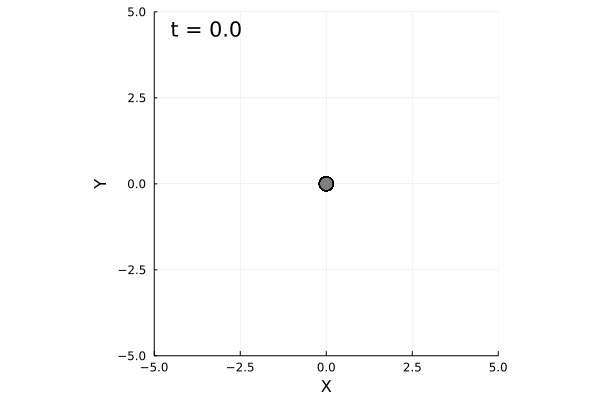

In [130]:
using .RealRobotWorld

world = RealRobotWorld.World(30, 0.1)

for i in 1:100
    circling = RealRobotWorld.Agent(0.2, 10.0/180*pi)
    r = RealRobotWorld.RealRobot([0, 0, pi/6], :gray, 0.2, circling)
    RealRobotWorld.append(world, r)
end

RealRobotWorld.RobotWorld.draw(world)